Number of pure strategies |X| = 21
Skew-symmetry check max |M + M^T| = 0.0

Hart strategy test:
  v(σ*,σ*) = 1.02798428206033e-18
  exploitability = 3.469446951953614e-18  (eps1, eps2) = (2.441462669893284e-18, 4.497431234013944e-18)

Seed 1: final (symmetrised at eval)
  value = -2.402545199786596e-06
  exploitability = 2.9534045073581483e-06  (eps1, eps2) = (4.310982356842061e-06, 1.595826657874236e-06)

Seed 2: final (symmetrised at eval)
  value = -2.165311405322656e-06
  exploitability = 5.422772750851904e-06  (eps1, eps2) = (6.845559207402147e-06, 3.999986294301661e-06)

Seed 3: final (symmetrised at eval)
  value = -2.1744029485743125e-06
  exploitability = 3.708196449999242e-06  (eps1, eps2) = (3.0906261334656097e-06, 4.3257667665328744e-06)

Seed 4: final (symmetrised at eval)
  value = 7.956798606408683e-07
  exploitability = 3.3047258617707115e-06  (eps1, eps2) = (2.647644115796017e-06, 3.961807607745406e-06)

Seed 5: final (symmetrised at eval)
  value = -6.777753538398547e

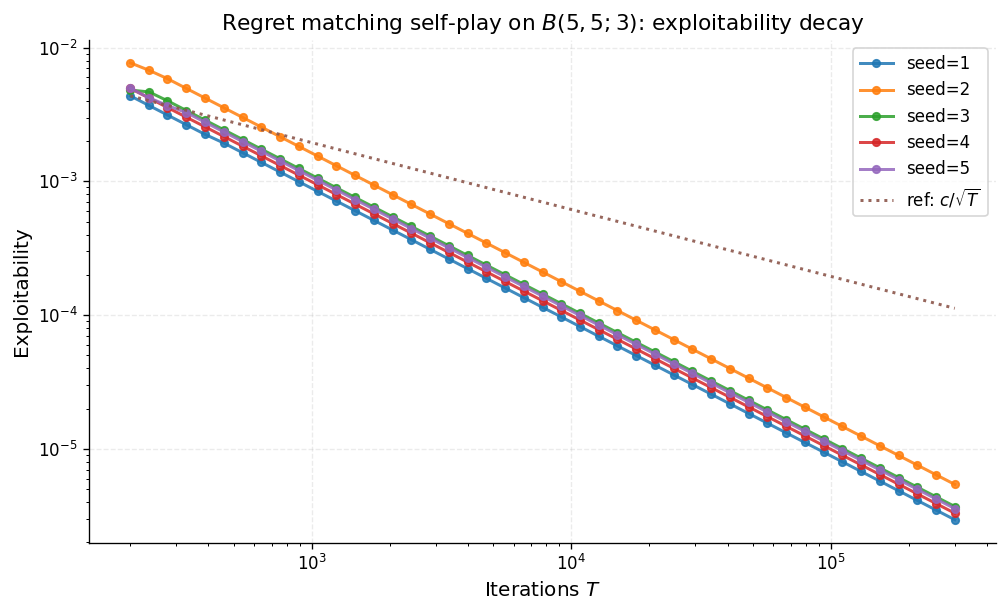

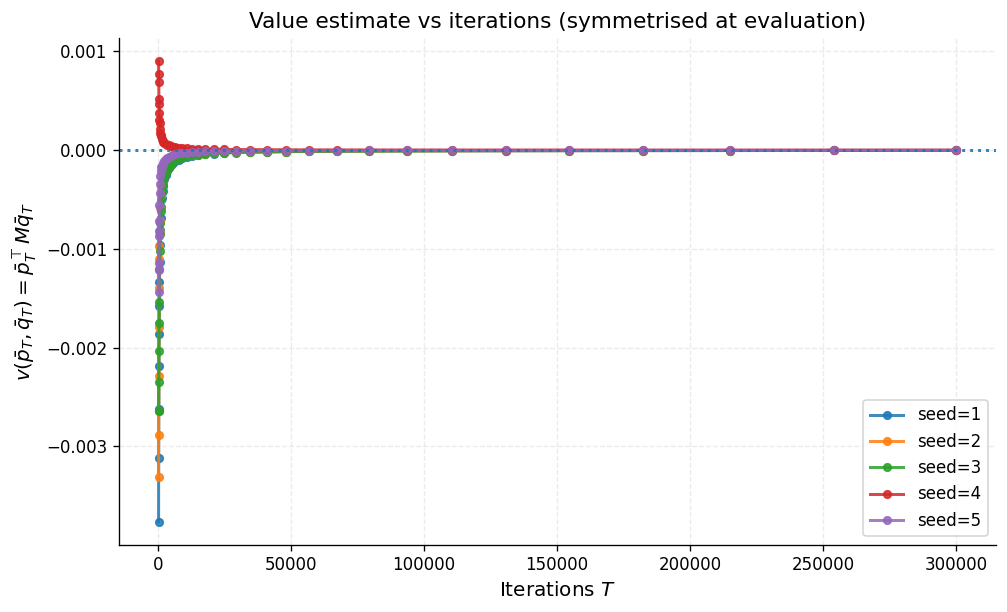

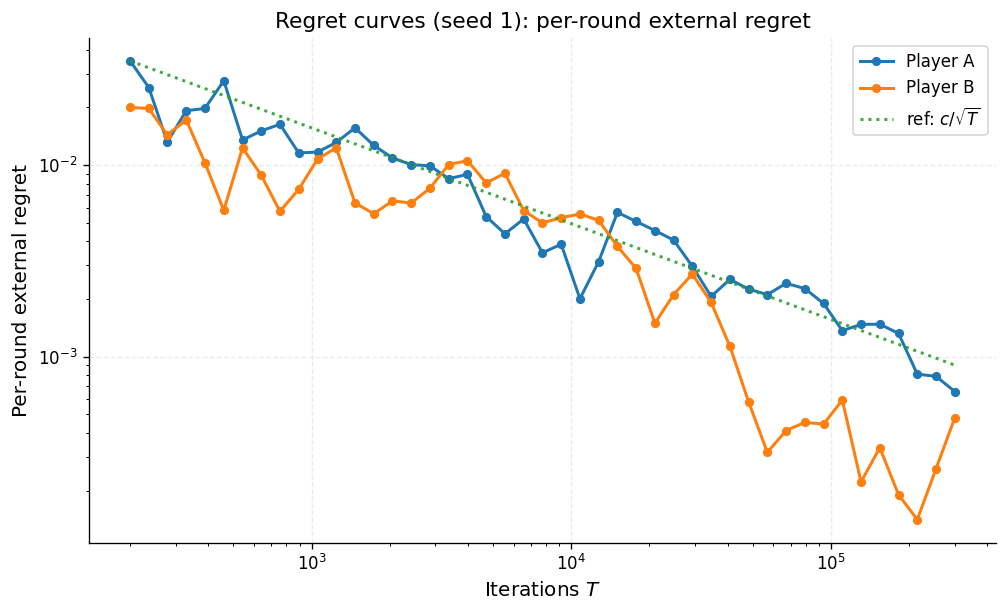

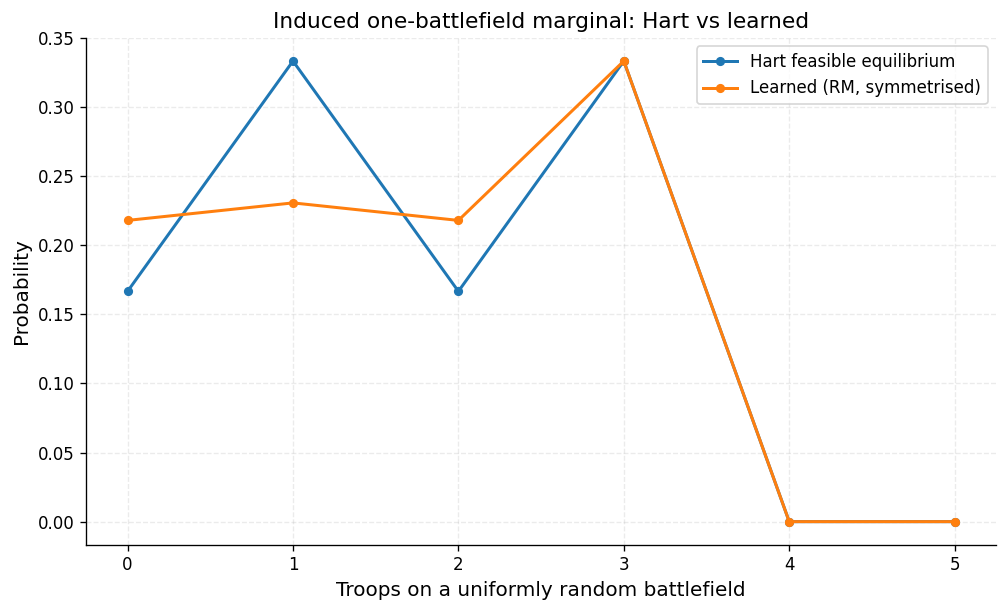

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import permutations


def set_nice_mpl_defaults():
    plt.rcParams.update({
        "figure.figsize": (8.5, 5.2),
        "figure.dpi": 120,
        "axes.grid": True,
        "grid.alpha": 0.25,
        "grid.linestyle": "--",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.titlesize": 13,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
        "lines.linewidth": 1.8,
        "lines.markersize": 4.5,
    })

def finalize_fig(title=None):
    if title is not None:
        plt.title(title)
    plt.tight_layout()

set_nice_mpl_defaults()


# 1) Game definition: labelled Colonel Blotto B(5,5;3)


def enumerate_allocations(A: int, K: int):
    """
    All K-tuples x in Z_{>=0}^K with sum x_k = A.

    Ordering for K=3 matches your paper:
    (0,0,A),(0,1,A-1),...,(0,A,0),(1,0,A-1),...,(A,0,0).
    """
    if K != 3:
        raise NotImplementedError("This ordering helper is implemented for K=3 only.")
    allocs = []
    for x1 in range(A + 1):
        for x2 in range(A - x1 + 1):
            x3 = A - x1 - x2
            allocs.append((x1, x2, x3))
    return allocs

def sgn(z: int) -> int:
    return 1 if z > 0 else (-1 if z < 0 else 0)

def u_stage(x, y):
    """u(x,y) = (1/K) sum_k sgn(x_k - y_k)."""
    K = len(x)
    return sum(sgn(x[k] - y[k]) for k in range(K)) / K

def payoff_matrix(actions):
    """Payoff matrix M_{ij} = u(actions[i], actions[j])."""
    n = len(actions)
    M = np.zeros((n, n), dtype=float)
    for i, x in enumerate(actions):
        for j, y in enumerate(actions):
            M[i, j] = u_stage(x, y)
    return M


# 2) Regret Matching + evaluation (exploitability, regrets, etc.)


def NormalizePos(R):
    """Algorithm 2: elementwise positive part then normalise, else uniform."""
    z = np.maximum(R, 0.0)
    s = float(z.sum())
    if s > 0:
        return z / s
    return np.ones_like(R) / len(R)

def sample_from_fast(p, rng):
    """Fast categorical sampler."""
    u = rng.random()
    return int(np.searchsorted(np.cumsum(p), u, side="right"))

def exploitability(M, p, q):
    """
    Half-sum exploitability for a zero-sum matrix game:
      v    = p^T M q
      brA  = max_i (M q)_i
      brB  = min_j (p^T M)_j
      eps1 = brA - v
      eps2 = v - brB
      expl = 0.5*(eps1+eps2)
    """
    v = float(p @ M @ q)
    brA = float((M @ q).max())
    brB = float((p @ M).min())
    eps1 = brA - v
    eps2 = v - brB
    return 0.5 * (eps1 + eps2), eps1, eps2, v, brA, brB

def symmetrise(actions, p):
    """
    Symmetrise p over battlefield permutations by averaging over permutation classes
    (same sorted pattern).
    """
    mass = defaultdict(float)
    count = defaultdict(int)
    pats = []
    for a, pi in zip(actions, p):
        c = tuple(sorted(a))
        pats.append(c)
        mass[c] += float(pi)
        count[c] += 1

    psym = np.zeros_like(p)
    for idx, c in enumerate(pats):
        psym[idx] = mass[c] / count[c]
    return psym

def induced_marginal(actions, p, A, K):
    """Marginal of X = x_I where I ~ Unif{1,...,K} under allocation distribution p."""
    marg = np.zeros(A + 1)
    for x, pi in zip(actions, p):
        for k in range(K):
            marg[x[k]] += pi * (1.0 / K)
    return marg

def regret_matching_self_play(
    M,
    actions,
    T=200_000,
    seed=0,
    checkpoints=None,
    sym_at_eval=True
):
    """
    Sampled-action RM self-play, logging:
      - exploitability / value
      - one-sided gaps eps1, eps2
      - best response values brA(q), brB(p)
      - external regret curves for both players (per-round)

    Returns:
      p_bar, q_bar, logs
    """
    rng = np.random.default_rng(seed)
    n = M.shape[0]

    R_A = np.zeros(n)   # cumulative regrets for A for each pure action
    R_B = np.zeros(n)   # cumulative regrets for B for each pure action

    sumP = np.zeros(n)  # average strategy accumulators
    sumQ = np.zeros(n)

    if checkpoints is None:
        checkpoints = np.unique(np.geomspace(200, T, num=45).astype(int))
        checkpoints = checkpoints[checkpoints <= T]
    checkpoints_set = set(int(c) for c in checkpoints)

    logs = {
        "t": [], "v": [], "expl": [], "eps1": [], "eps2": [],  # gaps
        "brA": [], "brB": [],                                    # best-response values
        "regA": [], "regB": [],                                  # per-round external regret
        "seed": seed
    }

    for t in range(1, T + 1):
        p_t = NormalizePos(R_A)
        q_t = NormalizePos(R_B)

        i_t = sample_from_fast(p_t, rng)
        j_t = sample_from_fast(q_t, rng)
        u_t = M[i_t, j_t]  # realised payoff to A (B gets -u_t)

        # unbiased realised external regret updates (as in your pseudocode)
        R_A = R_A + (M[:, j_t] - u_t)
        R_B = R_B + (u_t - M[i_t, :])

        sumP += p_t
        sumQ += q_t

        if t in checkpoints_set:
            p_bar = sumP / t
            q_bar = sumQ / t

            if sym_at_eval:
                p_eval = symmetrise(actions, p_bar)
                q_eval = symmetrise(actions, q_bar)
            else:
                p_eval, q_eval = p_bar, q_bar

            expl, eps1, eps2, v, brA, brB = exploitability(M, p_eval, q_eval)

            # per-round external regret (worst fixed-action deviation)
            regA = float(np.maximum(R_A, 0.0).max()) / t
            regB = float(np.maximum(R_B, 0.0).max()) / t

            logs["t"].append(t)
            logs["v"].append(v)
            logs["expl"].append(expl)
            logs["eps1"].append(eps1)
            logs["eps2"].append(eps2)
            logs["brA"].append(brA)
            logs["brB"].append(brB)
            logs["regA"].append(regA)
            logs["regB"].append(regB)

    p_bar = sumP / T
    q_bar = sumQ / T
    for k in ["t","v","expl","eps1","eps2","brA","brB","regA","regB"]:
        logs[k] = np.asarray(logs[k], dtype=float)
    return p_bar, q_bar, logs

# 3) Hart-feasible equilibrium for (A,K)=(5,3)


def hart_strategy_for_5_3(actions):
    """
    1/2 uniform over perms of (3,2,0) + 1/2 uniform over perms of (3,1,1)
    """
    def uniform_over_perms(vec):
        perms = set(permutations(vec))
        d = defaultdict(float)
        for p in perms:
            d[p] += 1.0 / len(perms)
        return d

    hart = defaultdict(float)
    for a, pi in uniform_over_perms((3, 2, 0)).items():
        hart[a] += 0.5 * pi
    for a, pi in uniform_over_perms((3, 1, 1)).items():
        hart[a] += 0.5 * pi

    idx = {a: i for i, a in enumerate(actions)}
    p_hart = np.zeros(len(actions))
    for a, pi in hart.items():
        p_hart[idx[a]] = pi
    return p_hart


# 4) Run + verification + plots + payoff-space viz + regrets


A, K = 5, 3
actions = enumerate_allocations(A, K)
M = payoff_matrix(actions)

print("Number of pure strategies |X| =", len(actions))
print("Skew-symmetry check max |M + M^T| =", np.max(np.abs(M + M.T)))

# Hart sanity check
p_hart = hart_strategy_for_5_3(actions)
exp_h, eps1_h, eps2_h, v_h, brA_h, brB_h = exploitability(M, p_hart, p_hart)
print("\nHart strategy test:")
print("  v(σ*,σ*) =", v_h)
print("  exploitability =", exp_h, " (eps1, eps2) =", (eps1_h, eps2_h))

# RM runs
T = 300_000
seeds = [1, 2, 3, 4, 5]
logs_list = []
finals = []

for sd in seeds:
    p_bar, q_bar, logs = regret_matching_self_play(M, actions, T=T, seed=sd, sym_at_eval=True)
    p_sym = symmetrise(actions, p_bar)
    q_sym = symmetrise(actions, q_bar)
    exp, eps1, eps2, v, brA, brB = exploitability(M, p_sym, q_sym)
    print(f"\nSeed {sd}: final (symmetrised at eval)")
    print("  value =", v)
    print("  exploitability =", exp, " (eps1, eps2) =", (eps1, eps2))
    logs_list.append(logs)
    finals.append((p_sym, q_sym, exp, v))

# pick one representative run (seed 1)
p_bar, q_bar, logs0 = regret_matching_self_play(M, actions, T=T, seed=seeds[0], sym_at_eval=False)

# symmetrise (must stay length 21)
p_sym = symmetrise(actions, p_bar)
q_sym = symmetrise(actions, q_bar)

# ============================================================
# PLOTS
# ============================================================

# ----------------------------
# Plot 1: exploitability vs T (log-log) + reference slope
# ----------------------------
plt.figure()
for logs in logs_list:
    plt.loglog(logs["t"], np.maximum(logs["expl"], 1e-12), marker="o", alpha=0.85)
# reference slope ~ c / sqrt(T) using first series scale
t_ref = logs_list[0]["t"]
c = logs_list[0]["expl"][0] * np.sqrt(t_ref[0])
plt.loglog(t_ref, np.maximum(c / np.sqrt(t_ref), 1e-12), linestyle=":", alpha=0.9)
plt.xlabel("Iterations $T$")
plt.ylabel("Exploitability")
plt.legend([f"seed={s}" for s in seeds] + [r"ref: $c/\sqrt{T}$"], loc="upper right")
finalize_fig("Regret matching self-play on $B(5,5;3)$: exploitability decay")
plt.show()

# ----------------------------
# Plot 2: value estimate vs T
# ----------------------------
plt.figure()
for logs in logs_list:
    plt.plot(logs["t"], logs["v"], marker="o", alpha=0.85)
plt.axhline(0.0, linestyle=":", alpha=0.9)
plt.xlabel("Iterations $T$")
plt.ylabel(r"$v(\bar p_T,\bar q_T)=\bar p_T^\top M \bar q_T$")
plt.legend([f"seed={s}" for s in seeds], loc="best")
finalize_fig("Value estimate vs iterations (symmetrised at evaluation)")
plt.show()

# ----------------------------
# Plot 3: regret curves (per-round external regret) for both players (one seed)
# ----------------------------
logs0 = logs_list[0]
plt.figure()
plt.loglog(logs0["t"], np.maximum(logs0["regA"], 1e-12), marker="o")
plt.loglog(logs0["t"], np.maximum(logs0["regB"], 1e-12), marker="o")
# reference slope ~ c / sqrt(T)
cA = logs0["regA"][0] * np.sqrt(logs0["t"][0])
plt.loglog(logs0["t"], np.maximum(cA / np.sqrt(logs0["t"]), 1e-12), linestyle=":", alpha=0.9)
plt.xlabel("Iterations $T$")
plt.ylabel("Per-round external regret")
plt.legend(["Player A", "Player B", r"ref: $c/\sqrt{T}$"], loc="upper right")
finalize_fig("Regret curves (seed 1): per-round external regret")
plt.show()

# ----------------------------
# Plot 4: induced one-battlefield marginal (Hart vs learned)
# ----------------------------
xs = np.arange(A + 1)
plt.figure()
plt.plot(xs, marg_hart, marker="o")
plt.plot(xs, marg_learn, marker="o")
plt.xlabel("Troops on a uniformly random battlefield")
plt.ylabel("Probability")
plt.legend(["Hart feasible equilibrium", "Learned (RM, symmetrised)"], loc="best")
finalize_fig("Induced one-battlefield marginal: Hart vs learned")
plt.show()



len(XA) = 21 M.shape = (21, 21)
max |M + M^T| = 0.0
Final exploitability: 0.0009256731305821745 Final value: -1.169677262463642e-06


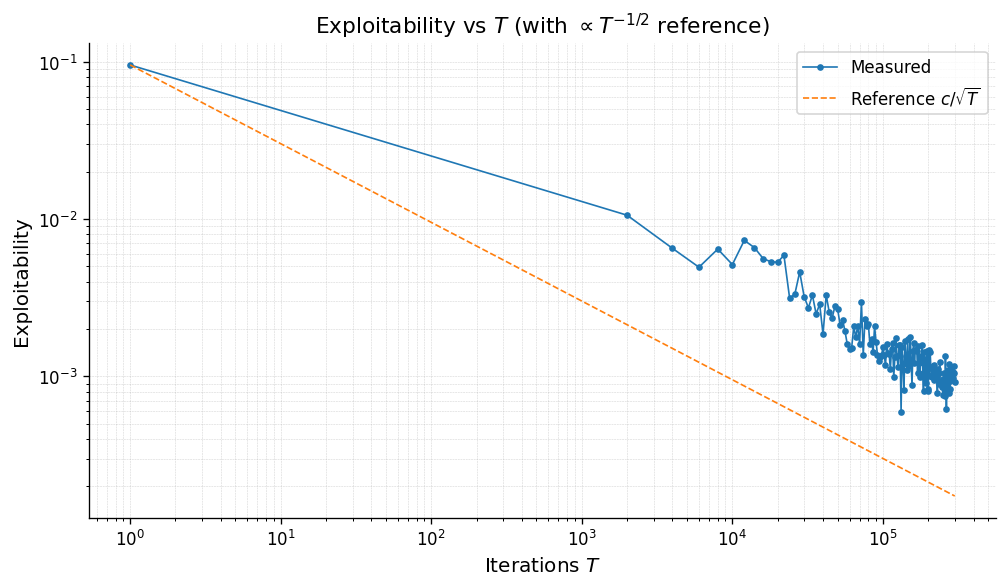

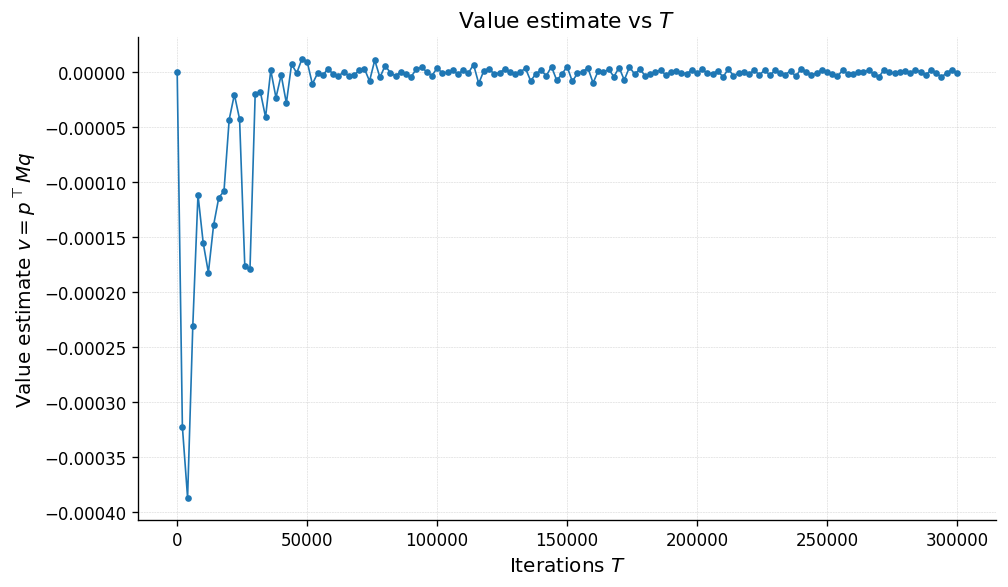

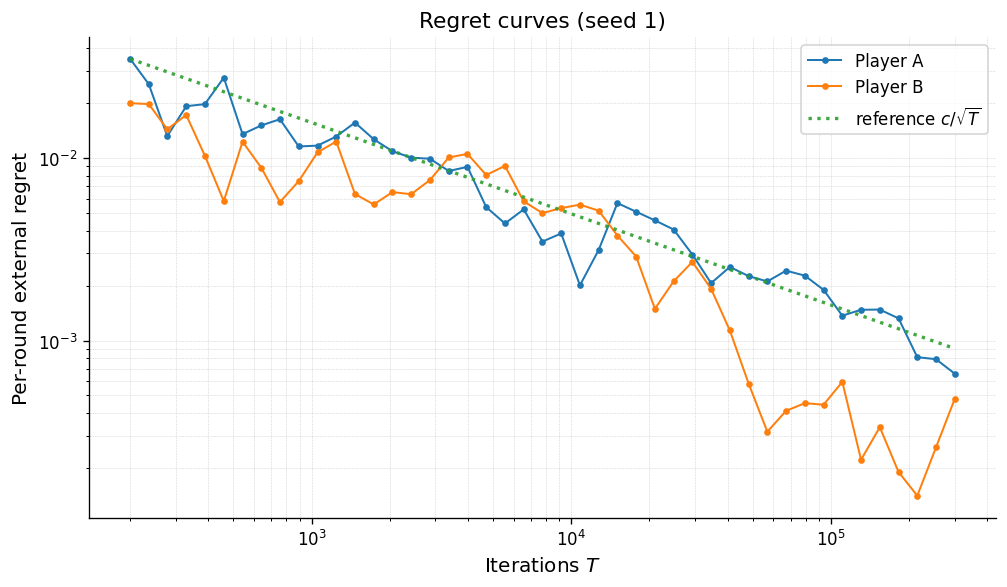

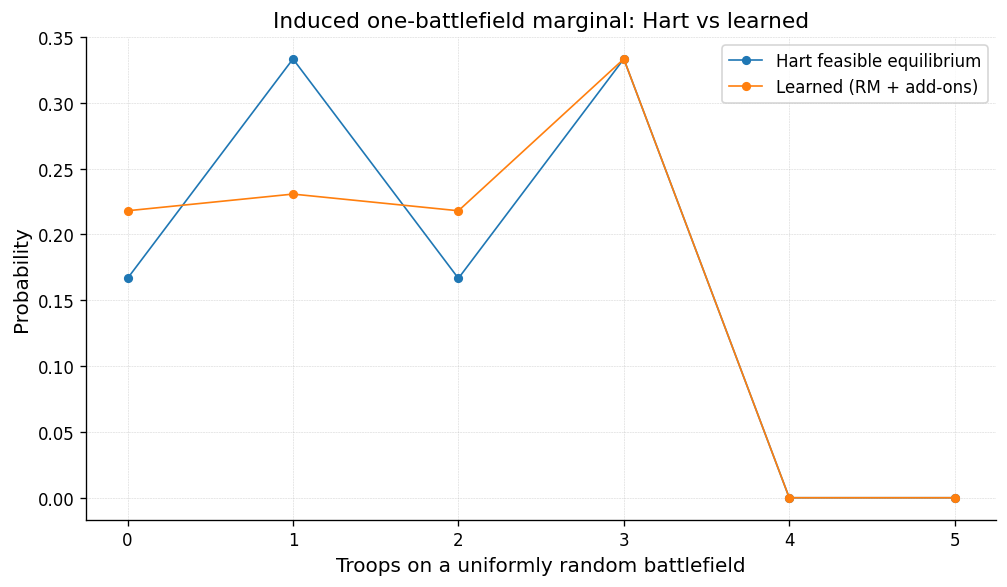

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import permutations


def enumerate_allocations(A: int, K: int):
    """All x in Z_{>=0}^K with sum x_k = A. Lexicographic recursion."""
    allocs = []

    def rec(prefix, remaining, k_left):
        if k_left == 1:
            allocs.append(tuple(prefix + [remaining]))
            return
        for x in range(remaining + 1):
            rec(prefix + [x], remaining - x, k_left - 1)

    rec([], A, K)
    return allocs

def sgn(z: int) -> int:
    return 1 if z > 0 else (-1 if z < 0 else 0)

def blotto_payoff(x, y):
    """u(x,y) = (1/K) sum_k sgn(x_k - y_k)."""
    K = len(x)
    return sum(sgn(x[k] - y[k]) for k in range(K)) / K

def blotto_payoff_matrix(A: int, B: int, K: int):
    """Return XA, YB, M with M[i,j]=u(XA[i],YB[j])."""
    XA = enumerate_allocations(A, K)
    YB = enumerate_allocations(B, K)
    M = np.zeros((len(XA), len(YB)), dtype=float)
    for i, x in enumerate(XA):
        for j, y in enumerate(YB):
            M[i, j] = blotto_payoff(x, y)
    return XA, YB, M


# 1) Utilities: RM + epsilon mixing + threshold/reset

def NormalizePos(R: np.ndarray) -> np.ndarray:
    """Elementwise positive part then normalise; fallback to uniform."""
    z = np.maximum(R, 0.0)
    s = float(z.sum())
    if s > 0.0:
        return z / s
    return np.ones_like(R) / len(R)

def eps_greedy_mix(p_rm: np.ndarray, eps: float) -> np.ndarray:
    """p = (1-eps)*p_rm + eps*Unif."""
    n = len(p_rm)
    u = np.ones(n) / n
    p = (1.0 - eps) * p_rm + eps * u
    p = np.maximum(p, 0.0)
    p /= p.sum()
    return p

def threshold_renormalize(p: np.ndarray, tau: float) -> np.ndarray:
    """Set entries < tau to 0 then renormalise; fallback to uniform if all removed."""
    if tau <= 0:
        return p
    q = p.copy()
    q[q < tau] = 0.0
    s = float(q.sum())
    if s > 0.0:
        q /= s
        return q
    return np.ones_like(p) / len(p)

def reset_accumulator_to_average(t: int, p_avg_new: np.ndarray) -> np.ndarray:
    """Enforce sumP/t = p_avg_new by setting sumP = t * p_avg_new."""
    return float(t) * p_avg_new


# 2) Exploitability + best-response diagnostics


def exploitability(M: np.ndarray, p: np.ndarray, q: np.ndarray):
    """
    Half-sum exploitability:
      v = p^T M q
      brA(q) = max_i (M q)_i
      brB(p) = min_j (p^T M)_j
      eps1 = brA - v
      eps2 = v - brB
      expl = 0.5*(eps1+eps2)
    """
    v = float(p @ M @ q)
    brA = float((M @ q).max())
    brB = float((p @ M).min())
    eps1 = brA - v
    eps2 = v - brB
    return 0.5 * (eps1 + eps2), eps1, eps2, v, brA, brB

def induced_marginal(actions, p, A, K):
    """Marginal of X = x_I where I ~ Unif{1,...,K}."""
    marg = np.zeros(A + 1)
    for x, pi in zip(actions, p):
        for k in range(K):
            marg[x[k]] += pi * (1.0 / K)
    return marg


# 3) Hart-feasible equilibrium for B(5,5;3)


def hart_strategy_for_5_3(actions):
    """1/2 uniform over perms of (3,2,0) + 1/2 uniform over perms of (3,1,1)."""
    def uniform_over_perms(vec):
        perms = set(permutations(vec))
        w = 1.0 / len(perms)
        return {p: w for p in perms}

    mass = defaultdict(float)
    for a, w in uniform_over_perms((3, 2, 0)).items():
        mass[a] += 0.5 * w
    for a, w in uniform_over_perms((3, 1, 1)).items():
        mass[a] += 0.5 * w

    idx = {a: i for i, a in enumerate(actions)}
    p = np.zeros(len(actions))
    for a, w in mass.items():
        p[idx[a]] = w
    return p


# 4) RM self-play with epsilon + threshold/reset + logging


def regret_matching_self_play(
    M: np.ndarray,
    T: int = 300_000,
    seed: int = 0,
    # epsilon model:
    eps0: float = 0.0,
    eps_decay: float = 1.0,      # e.g. 0.9999
    eps_min: float = 0.0,
    # thresholding:
    tau: float = 0.0,            # e.g. 0.001
    thresh_every: int = 0,       # e.g. 5000 (0 disables)
    # logging:
    log_every: int = 2000
):
    rng = np.random.default_rng(seed)
    n = M.shape[0]

    R_A = np.zeros(n)
    R_B = np.zeros(n)
    sumP = np.zeros(n)
    sumQ = np.zeros(n)

    logs = {
        "t": [], "eps": [],
        "v": [], "expl": [], "eps1": [], "eps2": [],
        "brA": [], "brB": [],
        "regA": [], "regB": []
    }

    eps = float(eps0)

    for t in range(1, T + 1):
        # base RM strategies
        p_rm = NormalizePos(R_A)
        q_rm = NormalizePos(R_B)

        # epsilon error modelling
        if eps > 0.0:
            p_t = eps_greedy_mix(p_rm, eps)
            q_t = eps_greedy_mix(q_rm, eps)
        else:
            p_t, q_t = p_rm, q_rm

        # sample realised actions
        i_t = rng.choice(n, p=p_t)
        j_t = rng.choice(n, p=q_t)
        u_t = M[i_t, j_t]

        # realised external regret updates (unbiased estimator)
        R_A += (M[:, j_t] - u_t)
        R_B += (u_t - M[i_t, :])

        # accumulate averages
        sumP += p_t
        sumQ += q_t

        # thresholding + resetting sums
        if thresh_every and tau > 0.0 and (t % thresh_every == 0):
            p_bar_tmp = threshold_renormalize(sumP / t, tau)
            q_bar_tmp = threshold_renormalize(sumQ / t, tau)
            sumP = reset_accumulator_to_average(t, p_bar_tmp)
            sumQ = reset_accumulator_to_average(t, q_bar_tmp)

        # logging
        if log_every and (t % log_every == 0 or t == 1):
            p_bar = sumP / t
            q_bar = sumQ / t

            expl, e1, e2, v, brA, brB = exploitability(M, p_bar, q_bar)

            # per-round worst positive cumulative regret proxy
            regA = float(np.max(np.maximum(R_A, 0.0)) / t)
            regB = float(np.max(np.maximum(R_B, 0.0)) / t)

            logs["t"].append(t)
            logs["eps"].append(eps)
            logs["v"].append(v)
            logs["expl"].append(expl)
            logs["eps1"].append(e1)
            logs["eps2"].append(e2)
            logs["brA"].append(brA)
            logs["brB"].append(brB)
            logs["regA"].append(regA)
            logs["regB"].append(regB)

        # epsilon decay
        eps = max(eps_min, eps * eps_decay)

    # convert logs
    for k in logs:
        logs[k] = np.array(logs[k], dtype=float) if k != "t" else np.array(logs[k], dtype=int)

    return (sumP / T, sumQ / T, logs)


# 5) Run B(5,5;3) + produce plots


A, B, K = 5, 5, 3
XA, YB, M = blotto_payoff_matrix(A, B, K)

print("len(XA) =", len(XA), "M.shape =", M.shape)
print("max |M + M^T| =", np.max(np.abs(M + M.T)))  # should be 0 (skew-symmetry)

# Hart baseline
p_hart = hart_strategy_for_5_3(XA)
marg_hart = induced_marginal(XA, p_hart, A, K)

# RM with your new add-ons
p_bar, q_bar, logs = regret_matching_self_play(
    M,
    T=300_000,
    seed=1,
    eps0=0.05,
    eps_decay=0.9999,
    eps_min=0.0,
    tau=0.001,
    thresh_every=5000,
    log_every=2000
)

print("Final exploitability:", logs["expl"][-1], "Final value:", logs["v"][-1])

# Learned marginal
marg_learn = induced_marginal(XA, p_bar, A, K)


# Plot 1: exploitability vs T (log-log) + reference slope ~ 1/sqrt(T)

plt.figure(figsize=(8.5, 5))
y = np.maximum(logs["expl"], 1e-12)
plt.loglog(logs["t"], y, marker="o", linewidth=1, markersize=3)
# reference line: c / sqrt(T) anchored at first point
t0 = float(logs["t"][0])
c = float(y[0]) * np.sqrt(t0)
ref = c / np.sqrt(logs["t"])
plt.loglog(logs["t"], ref, linestyle="--", linewidth=1)
plt.xlabel("Iterations $T$")
plt.ylabel("Exploitability")
plt.title("Exploitability vs $T$ (with $\\propto T^{-1/2}$ reference)")
plt.legend(["Measured", "Reference $c/\\sqrt{T}$"])
plt.grid(True, which="both", linewidth=0.3, alpha=0.6)
plt.tight_layout()


# Plot 2: value estimate vs T

plt.figure(figsize=(8.5, 5))
plt.plot(logs["t"], logs["v"], marker="o", linewidth=1, markersize=3)
plt.xlabel("Iterations $T$")
plt.ylabel("Value estimate $v = p^\\top M q$")
plt.title("Value estimate vs $T$")
plt.grid(True, linewidth=0.3, alpha=0.6)
plt.tight_layout()

# Plot 3: regret curves (per-round external regret proxy) for both players

logs0 = logs_list[0]   # one seed

plt.figure(figsize=(8.5, 5))

plt.loglog(
    logs0["t"],
    np.maximum(logs0["regA"], 1e-12),
    marker="o",
    linewidth=1.2,
    markersize=3,
)
plt.loglog(
    logs0["t"],
    np.maximum(logs0["regB"], 1e-12),
    marker="o",
    linewidth=1.2,
    markersize=3,
)

# reference slope c / sqrt(T)
c_ref = logs0["regA"][0] * np.sqrt(logs0["t"][0])
plt.loglog(
    logs0["t"],
    c_ref / np.sqrt(logs0["t"]),
    linestyle=":",
    linewidth=2,
    alpha=0.9,
)

plt.xlabel(r"Iterations $T$")
plt.ylabel(r"Per-round external regret")
plt.title("Regret curves (seed 1)")
plt.legend(
    ["Player A", "Player B", r"reference $c/\sqrt{T}$"],
    loc="upper right",
)
plt.grid(True, which="both", linewidth=0.3, alpha=0.6)
plt.tight_layout()
plt.show()



# Plot 4: induced one-battlefield marginal (Hart vs learned)

xs = np.arange(A + 1)
plt.figure(figsize=(8.5, 5))
plt.plot(xs, marg_hart, marker="o", linewidth=1)
plt.plot(xs, marg_learn, marker="o", linewidth=1)
plt.xlabel("Troops on a uniformly random battlefield")
plt.ylabel("Probability")
plt.title("Induced one-battlefield marginal: Hart vs learned")
plt.legend(["Hart feasible equilibrium", "Learned (RM + add-ons)"])
plt.grid(True, linewidth=0.3, alpha=0.6)
plt.tight_layout()

plt.show()
